# Mother Machine Data Pipeline for Symbiodinium cells

## Prerequsities: 
- your raw data is in tiff-file format (can be converted with eg. bioformats)
- you (manually) create a folder on your computer where you want to store all your results

### Import packages

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from PIL import Image
import imageio
import io
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
import warnings
import tifffile

import skimage
from skimage import io as skio, measure, segmentation, color
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.util import img_as_float, img_as_ubyte
from skimage.io import imread, imsave
from skimage.measure import regionprops

import napari
from tqdm import tqdm
import pandas as pd

import cellpose.models
from cellpose import io as cellpose_io
from cellpose import models, io


import seaborn as sns

### Define filepaths and create directories

In [148]:
"""INPUT INDEX OF FLUORESCENT AND BRIGHTFIELD CHANNELS""" 
birghtfield_channels = 0
fluorescent_channel = 1

"""INPUT PATH TO FOLDER YOU WANT OUTPUTS TO BE IN"""
output_folder = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all"


"""INPUT FILE PATH TO RAW-DATA TIFF-FILE"""
original_tiff_image_series = r"C:\Users\micha\Desktop\Master_Project\ORIGINAL_TIFF_Series_rawdata\new_data\converted_test_Z4.tiff"


#CREATE FOLDER WHERE ALL RESULTS FROM SPECIFIC RAW-DATA TIFF FILE TO SAVE
base_name = os.path.splitext(os.path.basename(original_tiff_image_series))[0]
result_folder = os.path.join(output_folder, f"MM_pipeline_results_{base_name}")
os.makedirs(result_folder, exist_ok=True)
print(f"Pipeline results for this specific TIFF-file (raw data) will be saved in the directory: {result_folder}")


#CREATE DIRECTORY TO SAVE THE CROPPED TRAPS IN
cropped_traps_output_dir = os.path.join(result_folder, "Cropped_traps_directory")
os.makedirs(cropped_traps_output_dir, exist_ok=True)


#CREATE DIRECTORY TO SAVE SEGMENTATION LABELS IN
labels_directory = Path(os.path.join(result_folder, "Labels_directory"))
labels_directory.mkdir(exist_ok=True)

#CREATE DIRECTORY TO SAVE FILTERED LABELS IN
filtered_labels_directory = Path(os.path.join(result_folder, "Filtered_labels"))
filtered_labels_directory.mkdir(exist_ok=True)

#CREATE DIRECTORY TO SAVE STACKED BRIGHTFIELD
stacked_brightfield = Path(os.path.join(result_folder, "Stacked_Brightfield_dir"))
stacked_brightfield.mkdir(exist_ok=True)


#READ IMAGES INTO PYTHON AND ROTATE THEM 
original_image_series = tifffile.imread(original_tiff_image_series)
rotated_image_series = np.rot90(original_image_series, k=-1, axes=(2, 3)) #2, 3 for 4D
print(rotated_image_series.shape)




fluor_files_dir = Path(os.path.join(result_folder, "Fluorescent_files_directory"))
fluor_files_dir.mkdir(exist_ok=True)

Pipeline results for this specific TIFF-file (raw data) will be saved in the directory: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_test_Z4
(275, 2, 2048, 2044)


### View the image series in Napari 
View your raw tiff image file in Napari to make sure it looks good

In [149]:
print("Original shape:", original_image_series.shape)

"""ADD NAMES AND COLORMAP FOR EACH CHANNEL YOU HAVE IN THE IMAGE"""
viewer = napari.view_image(
        rotated_image_series,
        channel_axis=1,
        name=["Brightfield", "Fluoresence (Red)"], #add name for each channel
        colormap=["gray", "red"] #add colormap for each channel
        )


Original shape: (275, 2, 2044, 2048)


In [14]:
#For 3D data
viewer = napari.Viewer()
viewer.add_image(rotated_image_series)

<Image layer 'rotated_image_series' at 0x166aed45250>

### Manual cropping of growth traps/channels for each image 
Manually draw boxes around traps (first frame of the tiff file), the coordinates for these will be saved and then used to crop all subsequent traps

In [196]:
matplotlib.use('Qt5Agg')  # Use 'Qt5Agg' backend

class ManualTrapCropping:
    def __init__(self, image_data, channel_index):
        self.image = image_data[channel_index]
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.image, cmap='gray')  # Display the image as grayscale
        self.rectangles = {}
        self.current_trap_index = 1
        self.first_rect_coords = None
        self.fixed_size = None
        self.rs = RectangleSelector(self.ax, self.on_rectangle_select,
                                     minspanx=5, minspany=5, spancoords='pixels', interactive=True)
        plt.connect('key_press_event', self.on_key_press)

    def on_rectangle_select(self, eclick, erelease):
        if self.fixed_size is None:
            # Store the dimensions of the first rectangle
            self.fixed_size = (erelease.xdata - eclick.xdata, erelease.ydata - eclick.ydata)

        # Use the fixed size for subsequent rectangles
        x_min, y_min = eclick.xdata, eclick.ydata
        x_max, y_max = x_min + self.fixed_size[0], y_min + self.fixed_size[1]

        # Save the rectangle coordinates globally
        global trap_coordinates_dict
        trap_coordinates_dict[self.current_trap_index] = (x_min, y_min, x_max, y_max)

    def on_key_press(self, event):
        if event.key == 'enter':
            # Draw the rectangle on the plot
            rect_coords = trap_coordinates_dict[self.current_trap_index]
            x_min, y_min, x_max, y_max = rect_coords
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            self.ax.add_patch(rect)
            plt.draw()

            # Increment the trap index for the next rectangle
            self.current_trap_index += 1

        elif event.key == 'q':
            # Print the final dictionary of rectangles
            print("Trap coordinates:", trap_coordinates_dict)
            plt.close()

# Initialize the dictionary globally
trap_coordinates_dict = {}

# Specify the channel index you want to crop
channel_index_to_crop = 0  # Adjust this to the desired channel index, best 

# Create an instance of ManualTrapCropping
manual_cropping = ManualTrapCropping(rotated_image_series[0], channel_index_to_crop)
plt.show()


Trap coordinates: {1: (140.79130472176848, 26.74325564060655, 346.2900002866893, 2017.1449069694102), 2: (1508.8254780539542, 26.74325564060655, 1714.324173618875, 2017.1449069694102)}


### Print height and width for each trap:

In [197]:
def calculate_rectangle_size(trap_coordinates_dict):
    sizes = {}

    for trap_index, coord in trap_coordinates_dict.items():
        x1, y1, x2, y2 = coord
        width = x2 - x1
        height = y2 - y1
        sizes[trap_index] = {'width': width, 'height': height}

    return sizes

# Example usage
rectangle_sizes = calculate_rectangle_size(trap_coordinates_dict)

for trap_index, size in rectangle_sizes.items():
    print(f"Trap {trap_index} Size: Width = {size['width']}, Height = {size['height']}")


Trap 1 Size: Width = 205.4986955649208, Height = 1990.4016513288036
Trap 2 Size: Width = 205.4986955649208, Height = 1990.4016513288036


### Visualisation of cropped traps
Visualises cropped traps for first and last frame 
- Check first and last frame to assess shifts in X and Y

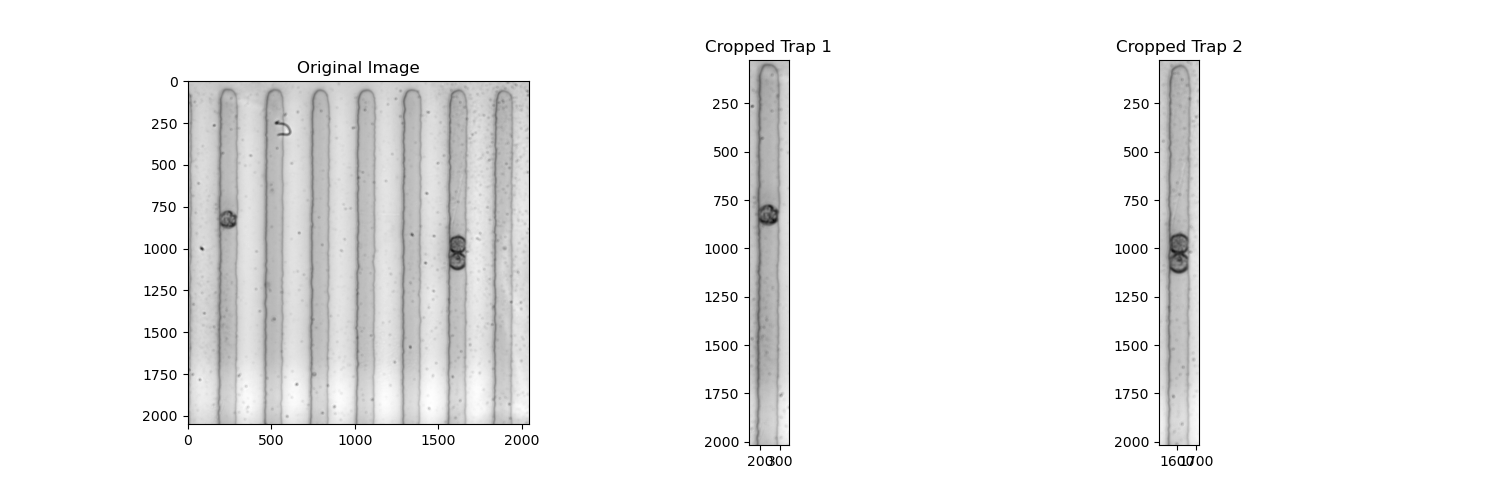

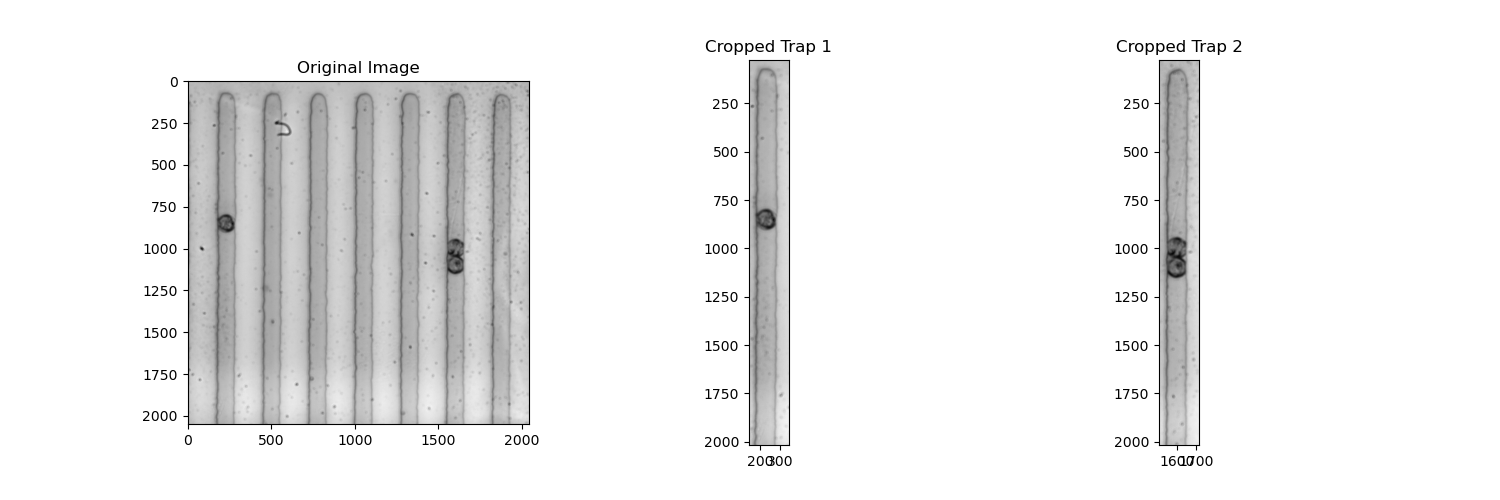

In [199]:
%matplotlib widget
import matplotlib.pyplot as plt

def crop_visualise_image(image_data, trap_coordinates_dict, channel_index):
    # Create subplots to display the original and cropped traps
    num_traps = len(trap_coordinates_dict)
    fig, axes = plt.subplots(1, num_traps + 1, figsize=(15, 5), squeeze=False)

    # Display the original image in grayscale
    original_channel = image_data[channel_index]
    axes[0, 0].imshow(original_channel, cmap='gray') 
    axes[0, 0].set_title("Original Image")

    # Crop the image based on the rectangles and display each cropped trap
    for i, (trap_index, rect_coords) in enumerate(trap_coordinates_dict.items(), start=1):
        x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values
    
        # Ensure coordinates are within the image boundaries
        x_min = max(0, x_min)
        x_max = min(original_channel.shape[1], x_max)
        y_min = max(0, y_min)
        y_max = min(original_channel.shape[0], y_max)
    
        # Crop the image
        cropped_trap = original_channel[y_min:y_max, x_min:x_max]
    
        # Display the cropped trap in grayscale
        axes[0, i].imshow(cropped_trap, cmap='gray', extent=(x_min, x_max, y_max, y_min))
        axes[0, i].set_title(f"Cropped Trap {trap_index}")

    plt.show()

# Example usage with trap_coordinates_dict and channel_index
channel_index_to_crop = 0 # Adjust this to the desired channel index
crop_visualise_image(rotated_image_series[0], trap_coordinates_dict, channel_index_to_crop)
crop_visualise_image(rotated_image_series[-1], trap_coordinates_dict, channel_index_to_crop)


### Crop the traps and save them as tiff-files (4D numpy-arrays (CTYX)) one for each trap
Crops the traps based on the manual selection and saves each trap in different folders which correspond to trap position 

In [200]:

# Define empty arrays
shape_minmax_list= []
cropped_traps_list = []
cropped_traps_dict = {}
# Loop to crop each trap
for trap_index, rect_coords in trap_coordinates_dict.items():
    x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values

    #Ensure trap-coordinates are within the image boundaries
    x_min = max(0, x_min)
    x_max = min(rotated_image_series.shape[-1], x_max)
    y_min = max(0, y_min)
    y_max = min(rotated_image_series.shape[-2], y_max)

    # Crop the image series
    cropped_trap = rotated_image_series[:, :, y_min:y_max, x_min:x_max]

    cropped_traps_dict[trap_index] = cropped_trap

    #add trap X&Y to list
    shape_minmax_list.append((cropped_trap.shape[-1], cropped_trap.shape[-2]))

# Find the maximum values for the first and second elements
transposed_list = list(zip(*shape_minmax_list))
max_X = max(transposed_list[0])
max_Y= max(transposed_list[1])


#for loop to save padded traps in array
for trap_index, cropped_trap in tqdm(cropped_traps_dict.items(), desc="Processing Traps", unit="trap"):
    #calculate padding based on max X&Y
    columns_to_pad = max(0, int(max_X) - cropped_trap.shape[-1])  # Pad along the last dimension (width/X)
    rows_to_pad = max(0, int(max_Y) - cropped_trap.shape[-2])  # Pad along the second-to-last dimension (height/Y)
    
    if columns_to_pad > 0 or rows_to_pad > 0:
        padded_trap = np.pad(cropped_trap, ((0, 0), (0, 0), (0, rows_to_pad), (0, columns_to_pad)), mode='constant', constant_values=0)
    else:
        padded_trap = cropped_trap

    cropped_traps_filename = f"cropped_trap_{trap_index}.tiff"
    cropped_traps_filepath = os.path.join(cropped_traps_output_dir, cropped_traps_filename)
    io.imsave(cropped_traps_filepath, padded_trap)




Processing Traps: 100%|██████████| 2/2 [00:03<00:00,  1.71s/trap]


### View the resulting cropped-trap tiff-files in Napari 
Specify which trap-series to view in the variable "trap_number_to_view"

In [201]:
"""CHANGE THIS TO THE DESIRED TRAP NUMBER TO VIEW"""
trap_number_to_view = 1  

In [203]:
import napari
from skimage import io as skio
from pathlib import Path

def load_trap_series(trap_number):
    # Construct the file path based on the trap number
    file_path = os.path.join(cropped_traps_output_dir, "cropped_trap_{}.tiff".format(trap_number))
    
    # Read the tiff file
    tiff_stack = skio.imread(file_path)
    print(tiff_stack.shape)
    return tiff_stack

# Load the tiff stack for the specified trap
trap_stack = load_trap_series(trap_number_to_view)

# Open Napari viewer
viewer = napari.Viewer()

# Add the tiff stack as a 3D layer
viewer.add_image(trap_stack, name=f'Trap {trap_number_to_view} - All Frames Series', colormap='gray')



(275, 2, 1991, 206)


<Image layer 'Trap 1 - All Frames Series' at 0x2d3b4c1d250>

### CELLPOSE on entire image series and saving labels in Labels_directory

- Parameters for the cellpose model as well as for filtering labels post segemenation

In [235]:
"""DEFINE CELLPOSE MODEL AND IF YOU HAVE GPU"""
model = models.Cellpose(gpu=False, model_type='cyto2')

"""DEFINE CHANNELS"""
#grayscale=0, R=1, G=2, B=3
#[cells, nucleus]
channels_cellpose = [0, 0]


#PARAMETERS FOR THE CELLPOSE MODEL
custom_params_segmentation = {
    'diameter': 90.0,
    'cellprob_threshold': 0.001,
    'flow_threshold': 0.6,
    #'min_size': 2000
}


In [236]:
img_dir = cropped_traps_output_dir
files_traps_tiff = [f for f in os.listdir(img_dir) if f.endswith('.tiff')]

# Loop through each tiff file 
for tiff_file_trap in files_traps_tiff:
    
    tiff_file_trap = Path(tiff_file_trap)
    tiff_path_trap = os.path.join(img_dir, tiff_file_trap)

    img_trap = tifffile.imread(tiff_path_trap)
    img_trap = img_trap[:, 0, :, :] #specify brightfield channel
    
    labels = np.zeros_like(img_trap, dtype=np.uint16)

    # Loop through each frame 
    for t in tqdm(range(img_trap.shape[0])):
    
            # Perform cellpose segmentation for each frame with eariler defined parameters
            masks_trap, _, _, _= model.eval(img_trap[t], channels=channels_cellpose, **custom_params_segmentation)

            labels_trap_frame = measure.label(masks_trap)
            labels[t] = labels_trap_frame

    
    labels_file_trap = labels_directory / f"labels_{tiff_file_trap.stem}.tiff"
    tifffile.imwrite(labels_file_trap, labels.astype(np.uint16))

100%|██████████| 275/275 [46:02<00:00, 10.05s/it]


### Cellpose and filtering function using local maxima

In [90]:
from pathlib import Path
import tifffile
# Collect original and labels file paths
original_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
original_image_file_paths = [str(file_path) for file_path in original_files]

labels_files = sorted(Path(labels_directory).glob("*.tiff"))
labels_file_paths = [str(file_path) for file_path in labels_files]

# Print original image file paths
print("Original Image Files:")
for img_path in original_image_file_paths:
    print(img_path)

# Print labels file paths
print("\nLabels Files:")
for label_path in labels_file_paths:
    print(label_path)

# Create a dictionary to store mappings between trap numbers and file paths
trap_data = {}

# Assuming the files are named in the format "cropped_trap_{trap_number}.tiff" and "labels_cropped_trap_{trap_number}.tiff"
for img_path, label_path in zip(original_image_file_paths, labels_file_paths):
    trap_number = int(img_path.split("_")[-1].split(".")[0])  # Extract trap number from file path
    trap_data[trap_number] = {'img': img_path, 'labels': label_path}

# Function to retrieve label and image paths for a given trap number
def get_paths(trap_number):
    return trap_data.get(trap_number, {'img': None, 'labels': None})




Original Image Files:
C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\cropped_trap_1.tiff
C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\cropped_trap_2.tiff
C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Cropped_traps_directory\cropped_trap_3.tiff

Labels Files:
C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Labels_directory\labels_cropped_trap_1.tiff
C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Labels_directory\labels_cropped_trap_2.tiff
C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Labels_directory\labels_cropped_trap_3.tiff


In [124]:
trap_number_to_filter = 3

In [125]:
paths = get_paths(trap_number_to_filter)
if paths['img'] and paths['labels']:
    img = tifffile.imread(paths['img'])
    labels = tifffile.imread(paths['labels'])
    print(f"Image shape for trap {trap_number_to_filter}: {img.shape}")
    print(f"Labels shape for trap {trap_number_to_filter}: {labels.shape}")
else:
    print(f"No data found for trap {trap_number_to_filter}")


Image shape for trap 3: (275, 2, 2035, 252)
Labels shape for trap 3: (275, 2035, 252)


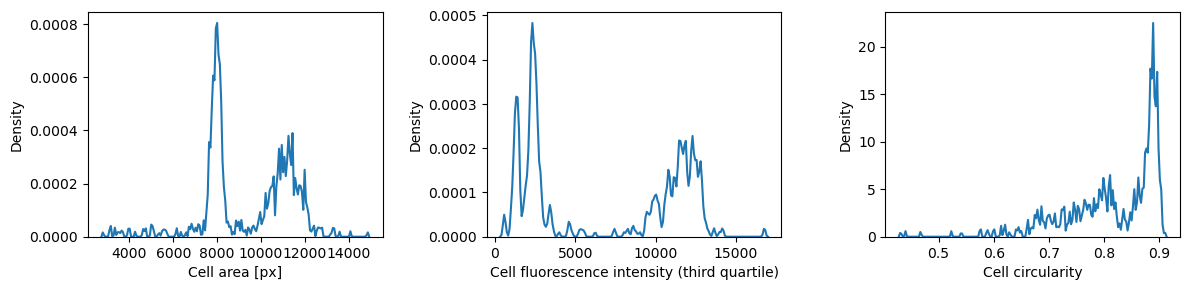

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define filtering thresholds
min_area_threshold = 1500  # Adjust as needed
max_area_threshold = 20000  # Adjust as needed
min_intensity_threshold = 500  # Adjust as needed

cell_areas_px = []
cell_fluorescence_intensity_Q3s = []
cell_circularities = []

for t in range(img.shape[0]):
    clear_labels = skimage.segmentation.clear_border(labels[t])
    regions = regionprops(clear_labels, intensity_image=np.moveaxis(img[t], 0, -1))
    for r in regions:
        if min_area_threshold <= r.area <= max_area_threshold:
            cell_areas_px.append(r.area)
            intensity_q3 = np.quantile(r.image_intensity[r.image, 1], 0.75)
            if intensity_q3 >= min_intensity_threshold:
                cell_fluorescence_intensity_Q3s.append(intensity_q3)
                # Calculate circularity
                circularity = (4 * np.pi * r.area) / (r.perimeter ** 2)
                cell_circularities.append(circularity)

warnings.filterwarnings("ignore")
fig, (lax, rax, cax) = plt.subplots(ncols=3, figsize=(12, 3), layout="constrained")
sns.kdeplot(x=cell_areas_px, bw_adjust=0.05, ax=lax)
lax.set_xlabel("Cell area [px]")
sns.kdeplot(x=cell_fluorescence_intensity_Q3s, bw_adjust=0.05, ax=rax)
rax.set_xlabel("Cell fluorescence intensity (third quartile)")
sns.kdeplot(x=cell_circularities, bw_adjust=0.05, ax=cax)
cax.set_xlabel("Cell circularity")
plt.tight_layout()
plt.show()


In [142]:
# Define parameters
min_cell_fluorescence_intensity_Q3 = 800 # Adjust as needed
min_cell_area_px = 4000  # Adjust as needed
max_cell_area_px = 13000  # Adjust as needed
min_circularity = 0.5 # Adjust as needed

In [143]:
filtered_labels = []

for t in tqdm(range(img.shape[0])):
    filtered_labels_list = []
    clear_labels = skimage.segmentation.clear_border(labels[t])
    for r in regionprops(clear_labels, intensity_image=np.moveaxis(img[t], 0, -1)):
        # Additional filtering steps
        if (np.quantile(r.image_intensity[r.image, 1], 0.75) >= min_cell_fluorescence_intensity_Q3 and
            r.area >= min_cell_area_px and
            r.area <= max_cell_area_px and
            r.perimeter != 0):  # Ensure not dividing by zero
           
            # Calculate circularity
            circularity = (4 * np.pi * r.area) / (r.perimeter ** 2)

            # Check circularity threshold
            if circularity >= min_circularity:
                filtered_labels_list.append(r.label)

    current_filtered_labels = np.where(np.isin(clear_labels, filtered_labels_list), clear_labels, 0)
    filtered_labels.append(current_filtered_labels)

filtered_labels = np.array(filtered_labels)


100%|██████████| 275/275 [00:04<00:00, 63.09it/s]


In [144]:
viewer = napari.Viewer()

image_layer = viewer.add_image(img, name="trap", channel_axis=1, colormap='gray')

unfiltered_labels_layer = viewer.add_labels(labels, name="Nuclei (unfiltered)")
filtered_labels_layer = viewer.add_labels(filtered_labels, name="Nuclei (filtered)")


### All image files instead of one

In [185]:
original_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
original_image_file_paths = [str(file_path) for file_path in original_files]

bfimage_arrays = [imageio.imread(file_path) for file_path in original_image_file_paths]
stacked_array = np.stack(bfimage_arrays)
reshaped_array = stacked_array.reshape(-1, *stacked_array.shape[2:])
print(reshaped_array.shape)
labels_files = sorted(Path(labels_directory).glob("*.tiff"))
labels_file_paths = [str(file_path) for file_path in labels_files]


(825, 2, 2035, 252)


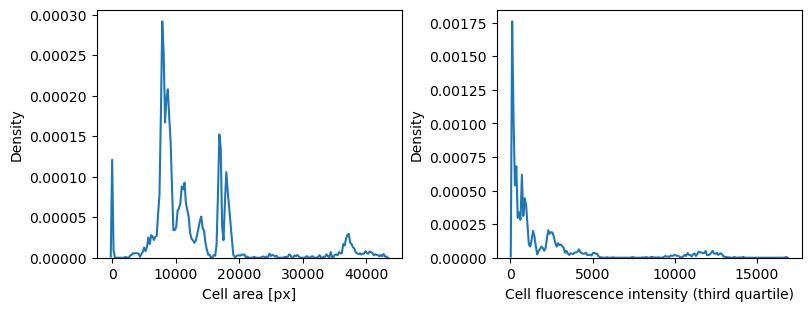

In [156]:
cell_areas_px = []
cell_fluorescence_intensity_Q3s = []

for label_path, img_path in zip(labels_file_paths, original_image_file_paths):
    labels = tifffile.imread(label_path)
    img = tifffile.imread(img_path)
    # Assuming img_trap, labels, and img are loaded from the file
    for t in range(img_trap.shape[0]):
        regions = regionprops(labels[t], intensity_image=np.moveaxis(img[t], 0, -1))
        cell_areas_px += [r.area for r in regions]
        cell_fluorescence_intensity_Q3s += [np.quantile(r.image_intensity[r.image, 1], 0.75) for r in regions]

fig, (lax, rax) = plt.subplots(ncols=2, figsize=(8, 3), layout="constrained")
sns.kdeplot(x=cell_areas_px, bw_adjust=0.05, ax=lax)
lax.set_xlabel("Cell area [px]")
sns.kdeplot(x=cell_fluorescence_intensity_Q3s, bw_adjust=0.05, ax=rax)
rax.set_xlabel("Cell fluorescence intensity (third quartile)")
plt.show()

In [191]:
# minimum cell area, in pixels
min_cell_area_px = 4000

# minimum cell fluorescence intensity (third quartile)
min_cell_fluorescence_intensity_Q3 = 800


In [192]:
filtered_labels = []

for label_path, img_path in zip(labels_file_paths, original_image_file_paths):
    labels = tifffile.imread(label_path)
    img = tifffile.imread(img_path)
    for t in range(img.shape[0]):
        filtered_labels_list = [
            r.label for r in regionprops(labels[t], intensity_image=np.moveaxis(img[t], 0, -1))
            if np.quantile(r.image_intensity[r.image, 1], 0.75) >= min_cell_fluorescence_intensity_Q3
            and r.area >= min_cell_area_px
        ]
        current_filtered_labels = np.where(np.isin(labels[t], filtered_labels_list), labels[t], 0)
        filtered_labels.append(current_filtered_labels)
    
filtered_labels = np.array(filtered_labels)


In [193]:
viewer = napari.Viewer()
image_layer = viewer.add_image(reshaped_array, name="trap", channel_axis=1, colormap='gray')
filtered_labels_layer = viewer.add_labels(filtered_labels, name="Nuclei (filtered)")


### Process traps for downstream analysis:

- Stack cropped traps vertically for Napari visualisation (Birghtfield)

In [4]:
croppedtrap_frames_list = []

original_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
original_image_file_paths = [str(file_path) for file_path in original_files]

for frame_index in tqdm(range(len(tifffile.imread(original_image_file_paths[0])))):

    original_frames_for_timepoint = []

    for original_image_tiff in original_image_file_paths:
        original_image_array = tifffile.imread(original_image_tiff)[:, 0, :, :]
        original_frame = original_image_array[frame_index]

        original_frames_for_timepoint.append(original_frame)
        
    croppedtrap_stacked_frames_for_timepoint = np.vstack(original_frames_for_timepoint)
    croppedtrap_frames_list.append(croppedtrap_stacked_frames_for_timepoint) 

croppedtrap_frames_array = np.stack(croppedtrap_frames_list)

stacked_brightfield_file = stacked_brightfield / "stacked_brightfield.tiff"
tifffile.imwrite(stacked_brightfield_file, croppedtrap_frames_array)


Processing Frames: 100%|██████████| 275/275 [07:00<00:00,  1.53s/it]


- Stack cropped traps vertically for Napari visualisation (Fluorescent)

In [29]:
fluortrap_frames_list = []

fluorescence_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
fluorescence_image_file_paths = [str(file_path) for file_path in fluorescence_files]

for frame_index in tqdm(range(len(tifffile.imread(fluorescence_image_file_paths[0])))):

    fluorescence_frames_for_timepoint = []

    for fluorescence_image_tiff in fluorescence_image_file_paths:
        fluorimage_array = tifffile.imread(fluorescence_image_tiff)[:, 1, :, :]
        fluorescence_frame = fluorimage_array[frame_index]

        fluorescence_frames_for_timepoint.append(fluorescence_frame)
        
    fluortrap_stacked_frames_for_timepoint = np.vstack(fluorescence_frames_for_timepoint)
    fluortrap_frames_list.append(fluortrap_stacked_frames_for_timepoint) 

fluortrap_frames_array = np.stack(fluortrap_frames_list)

stacked_fluorescence_file = fluor_files_dir / "stacked_fluorescence.tiff"
tifffile.imwrite(stacked_fluorescence_file, fluortrap_frames_array)


Processing Frames: 100%|██████████| 275/275 [04:08<00:00,  1.11it/s]


- Save fluorescent channel into separate directory (needed for filtering function) 

In [20]:
original_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
original_image_file_paths = [str(file_path) for file_path in original_files]

fluor_files_dir = Path(os.path.join(result_folder, "Fluorescent_files_directory"))
fluor_files_dir.mkdir(exist_ok=True)

for twochannel_files in original_image_file_paths: 
    twochannel_img = tifffile.imread(twochannel_files)
    twochannel_img = twochannel_img[:, 1, :, :]

    output_fluor_file_path = os.path.join(fluor_files_dir, f"fluorescent_{Path(twochannel_files).stem}.tiff")

    tifffile.imwrite(output_fluor_file_path, twochannel_img)
    print("File saved")


File saved
File saved
File saved


### Visualisation of labels 

In [23]:
filtered_frames_list = []  # List to store individual filtered frames
unfiltered_frames_list = []  # List to store individual filtered frames

#list files in labels and fluorescent images directory
labels_files = sorted(Path(labels_directory).glob("*.tiff"))
labels_file_paths = [str(file_path) for file_path in labels_files]

fluorescent_files = sorted(Path(fluor_files_dir).glob("*.tiff"))
fluorescent_files_paths = [str(file_path) for file_path in fluorescent_files]


# Iterate over frames for each time point and stack frames across files
for frame_index in tqdm(range(len(tifffile.imread(labels_file_paths[0]))), desc="Processing Frames"):
    
    #create empty lists to store data for time points:
    filtered_frames_for_timepoint = []  
    unfiltered_frames_for_timepoint = []

    for label_tiff, fluor_tiff in zip(labels_file_paths, fluorescent_files_paths):
        labels_array = tifffile.imread(label_tiff)
        fluorimg_array = tifffile.imread(fluor_tiff)
        
        label_frame = labels_array[frame_index]
        fluor_frame = fluorimg_array[frame_index]

        
        filtered_labels = refine_segmentations(label_frame, fluor_frame) #filtering function
        
        filtered_frames_for_timepoint.append(filtered_labels)
        
        unfiltered_frames_for_timepoint.append(label_frame)        
        
        

    # Vertically stack frames for each time point across files (filtered labels)
    stacked_frames_for_timepoint = np.vstack(filtered_frames_for_timepoint)
    filtered_frames_list.append(stacked_frames_for_timepoint)
    
    #stack unfiltered labels
    unfiltered_stacked_frames_for_timepoint = np.vstack(unfiltered_frames_for_timepoint)
    unfiltered_frames_list.append(unfiltered_stacked_frames_for_timepoint)

# Combine the stacked frames for all time points into a single array

filtered_frames_array = np.stack(filtered_frames_list)
unfiltered_frames_array = np.stack(unfiltered_frames_list)

#Saves the vertically stacked filtered labels for the timepoints
Path_filtered = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Filtered_labels\filtered_labels.tiff"
tifffile.imsave(Path_filtered, filtered_frames_array)

Processing Frames: 100%|██████████| 275/275 [11:12<00:00,  2.45s/it]
C:\Users\micha\AppData\Local\Temp\ipykernel_17220\1377631549.py:57: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(Path_filtered, filtered_frames_array)


- visualise vertical stacks of filtered and unfiltered labels, as well as brightfield stack in napari

In [31]:
#Stacked brightfield
stacked_brightfield_file = stacked_brightfield / "stacked_brightfield.tiff"
brightfield_stack = tifffile.imread(stacked_brightfield_file)


fluor_stack = tifffile.imread(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Fluorescent_files_directory\stacked_fluorescence.tiff")
## Display the combined stacked arrays as a single layer in Napari
viewer = napari.Viewer()
viewer.add_image(fluor_stack, name="Cropped Fluorescnt Traps", colormap = "magenta")

viewer.add_labels(filtered_frames_array, name="Filtered Labels")
viewer.add_labels(unfiltered_frames_array, name="Unfiltered Labels")

viewer.add_image(brightfield_stack, name="Cropped BF Traps")




<Image layer 'Cropped BF Traps' at 0x1caa7ee8440>

### Extract region props from the images
- extracts from filtered labels stack

In [58]:
from skimage import measure
import numpy as np
import tifffile
from pathlib import Path

# Specify the directory containing TIFF files
tiff_directory = Path(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1\Filtered_labels")

# Get a list of TIFF file paths in the directory
tiff_files = sorted(tiff_directory.glob("*.tiff"))

# Create an empty dictionary to store region properties
regionprops_dict = {}

# Iterate over TIFF files in the directory
for tiff_path in tiff_files:
    # Read the TIFF file
    tiff_array = tifffile.imread(tiff_path)

    # Iterate over time points in the TIFF array
    for timepoint, frame in enumerate(tiff_array, start=1):  # Start timepoint index from 1
        # Convert the binary image to an integer type
        labeled_frame = measure.label(frame.astype(np.uint16))

        # Extract region properties from the labeled frame
        region_props_dict = {}
        for region in measure.regionprops(labeled_frame):
            label_key = f"label {region.label}"
            label_props = {
                "area": region.area,
                "centroid": region.centroid,
                "equivalent_diameter": 2 * np.sqrt(region.area / np.pi),
                "eccentricity": region.eccentricity,
                # Add more properties as needed
            }
            region_props_dict[label_key] = label_props

        # Add region properties to the overall dictionary with frame and label keys
        frame_key = f"frame {timepoint}"
        regionprops_dict.setdefault(frame_key, {}).update(region_props_dict)

# Now, regionprops_dict contains region properties for each timepoint and label with frame and label keys
#print(regionprops_dict)


### plotting: 

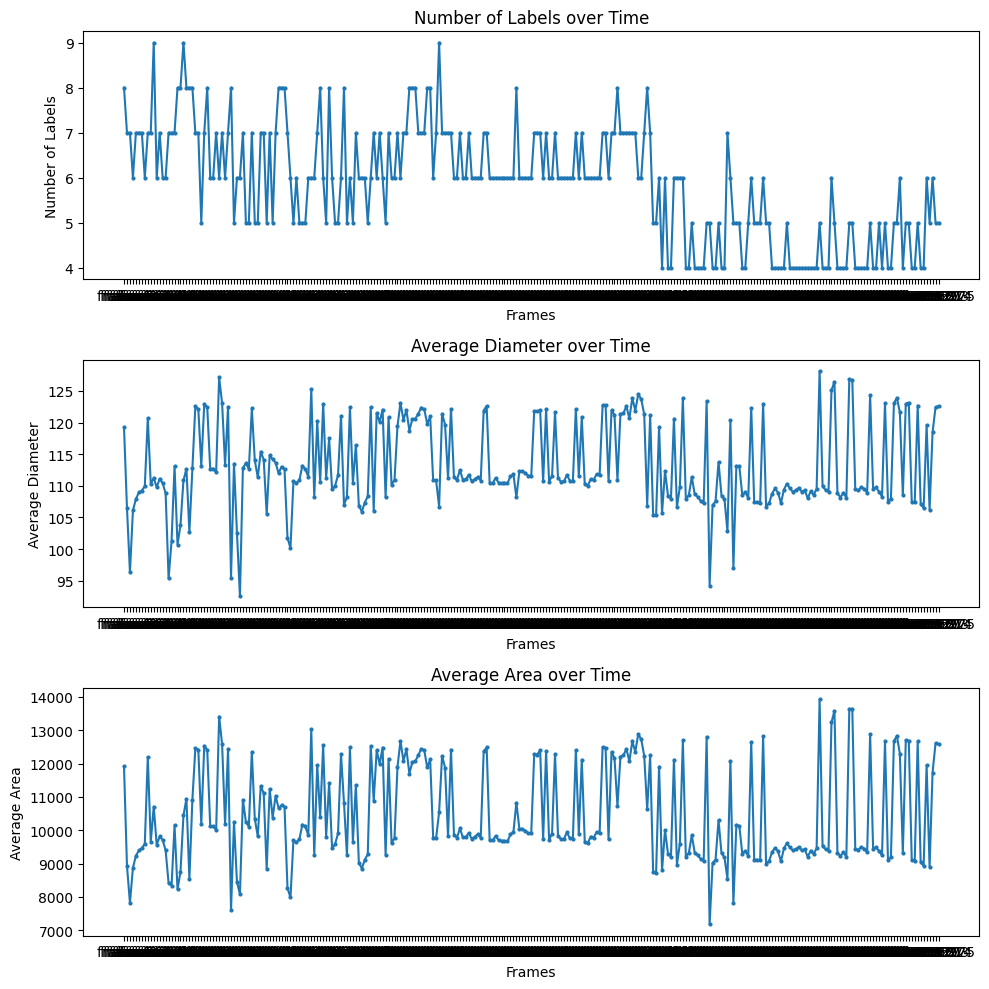

In [59]:
# Extract data for plotting

    
timepoints = regionprops_dict.keys()
num_labels = [len(regionprops) for timepoint, regionprops in regionprops_dict.items()]
average_areas = [np.mean([props["area"] for props in regionprops.values()]) for timepoint, regionprops in regionprops_dict.items()]
average_diameters = [np.mean([props["equivalent_diameter"] for props in regionprops.values()]) for timepoint, regionprops in regionprops_dict.items()]


# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot Number of Labels
axs[0].plot(timepoints, num_labels, marker='o', markersize=2)
axs[0].set_title('Number of Labels over Time')
axs[0].set_xlabel('Frames')
axs[0].set_ylabel('Number of Labels')

# Plot Average Diameter
axs[1].plot(timepoints, average_diameters, marker='o', markersize=2)
axs[1].set_title('Average Diameter over Time')
axs[1].set_xlabel('Frames')
axs[1].set_ylabel('Average Diameter')

# Plot Average Area
axs[2].plot(timepoints, average_areas, marker='o', markersize=2)
axs[2].set_title('Average Area over Time')
axs[2].set_xlabel('Frames')
axs[2].set_ylabel('Average Area')

# Adjust x-axis ticks and label
plt.tight_layout()
plt.show()


- Individual labels

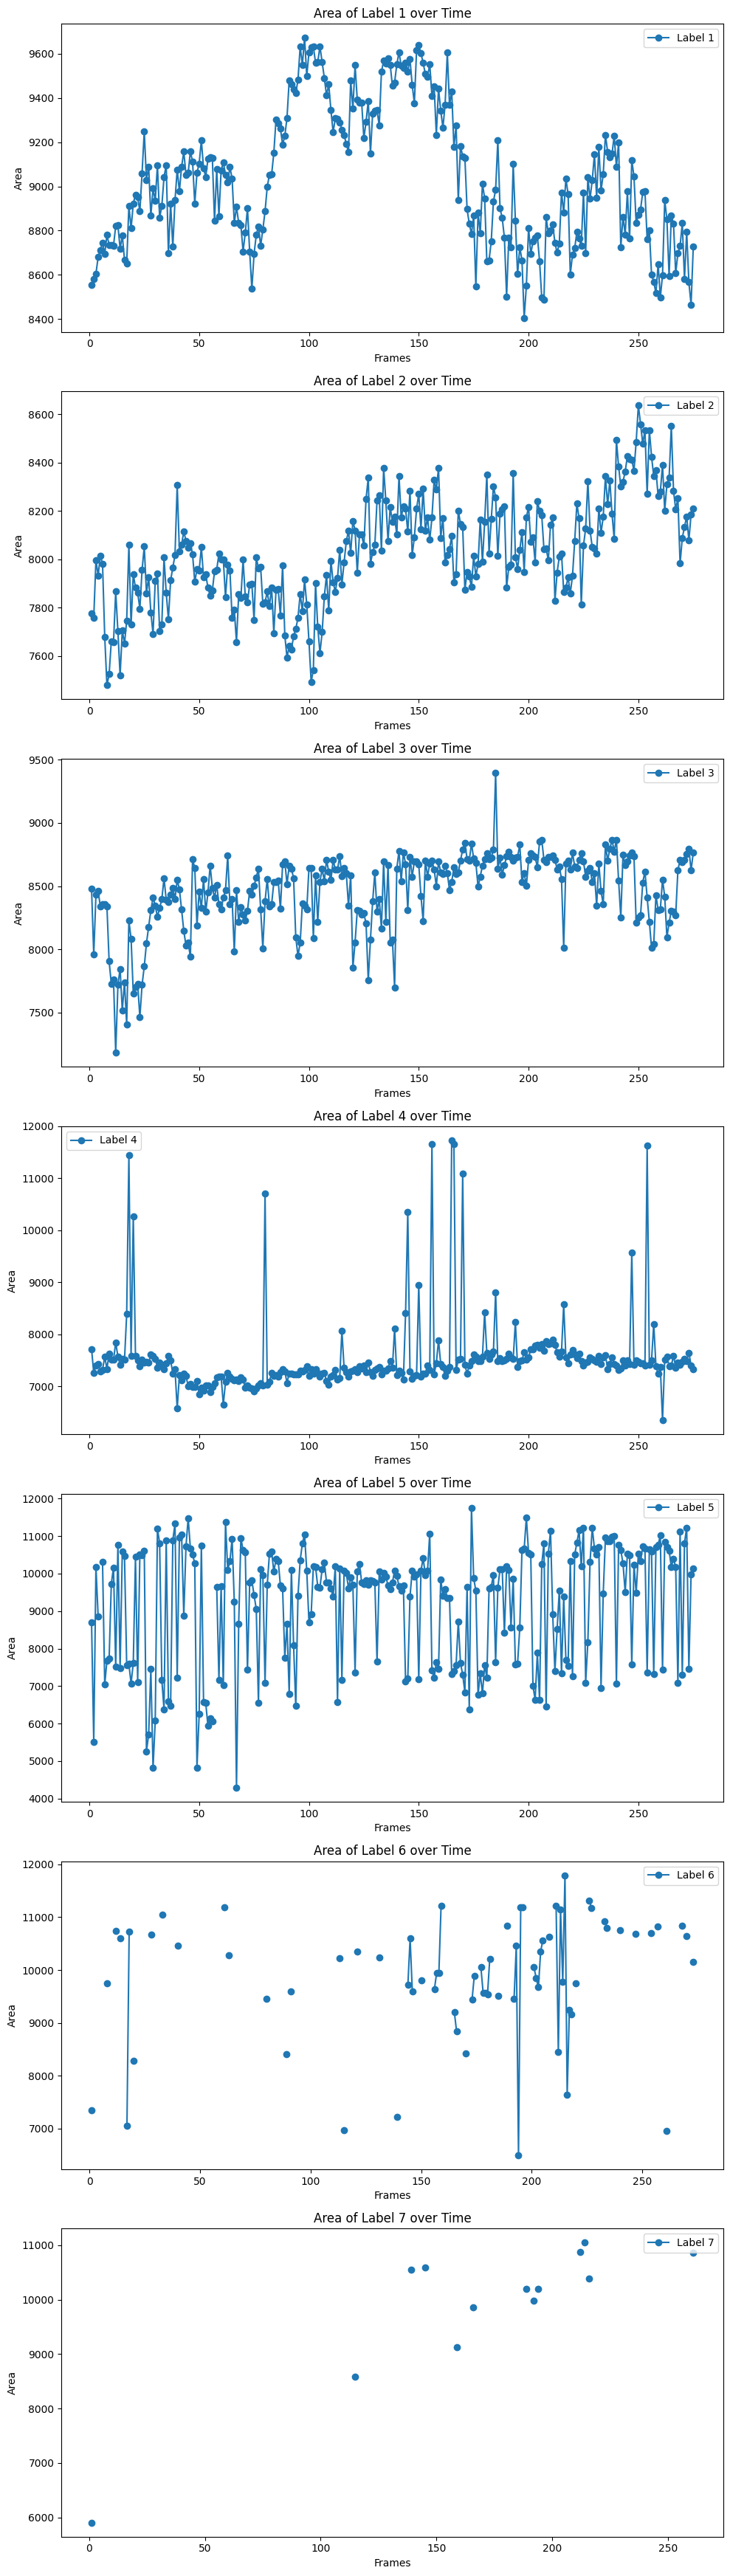

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
timepoints = list(range(1, len(regionprops_dict) + 1))

# Create a separate plot for each label
fig, axs = plt.subplots(len(regionprops_dict['frame 1']), 1, figsize=(10, 5 * len(regionprops_dict['frame 1'])))

for label_num in range(1, len(regionprops_dict['frame 1']) + 1):
    # Check if the label exists in any frame
    if any(f'label {label_num}' in regionprops_dict[f'frame {t}'] for t in timepoints):
        # Extract data for the current label over time
        area_data = [regionprops_dict.get(f'frame {t}', {}).get(f'label {label_num}', {}).get('area', np.nan) for t in timepoints]

        # Plotting
        axs[label_num - 1].plot(timepoints, area_data, marker='o', label=f'Label {label_num}')
        axs[label_num - 1].set_title(f'Area of Label {label_num} over Time')
        axs[label_num - 1].set_xlabel('Frames')
        axs[label_num - 1].set_ylabel('Area')
        axs[label_num - 1].legend()

plt.tight_layout()
plt.show()
